In [12]:
import numpy as np
import pandas as pd
import missingno as msno
import time
import os
from purpleair.sensor import Sensor


import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# load the states shape data
def load_states_data():
    !rm states*
    !curl -LJO https://github.com/josh-tollefson/aqi/raw/master/notebooks/states_21basic.zip
    !ls 
    !unzip states_21basic.zip 
    !ls


In [4]:
usa = gpd.read_file('states.shp')
display(usa.head(2))
display(usa.tail(1))

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."


,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
50,Alaska,51,02,Pacific,AK,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."


In [14]:
def get_sensor_list():
    from purpleair.network import SensorList
    return SensorList()  
    
p = get_sensor_list()

sensors_df = p.to_dataframe(sensor_filter='column',
                    column='6hour_avg',
                    channel='parent')
sensors_df.to_csv('Sensors_from_purpleair.csv')
sensors_df.head()


Initialized 13,904 sensors!


,parent,lat,lon,name,location_type,pm_2.5,temp_f,temp_c,humidity,pressure,...,last_update_check,created,uptime,is_owner,10min_avg,30min_avg,1hour_avg,6hour_avg,1day_avg,1week_avg
id,,,,,,,,,,,,,,,,,,,,,
14633,None,37.275561,-121.964134,Hazelwood canary,outside,3.07,102.0,38.888889,8.0,1008.09,...,None,None,None,False,3.34,3.02,2.62,3.85,6.66,21.70
25999,None,30.053808,-95.494643,Villages of Bridgestone AQI,outside,16.16,97.0,36.111111,40.0,1006.84,...,None,None,None,False,15.75,15.30,15.21,18.48,18.74,17.81
14091,None,37.883620,-122.070087,WC Hillside,outside,0.91,92.0,33.333333,11.0,1003.22,...,None,None,None,False,1.09,1.18,1.31,2.91,5.90,28.49
42073,None,47.185173,-122.176855,#1,outside,6.47,64.0,17.777778,50.0,1013.89,...,None,None,None,False,6.21,5.46,4.97,3.57,3.36,18.67
53069,None,47.190197,-122.177992,#2,outside,6.66,77.0,25.000000,33.0,1013.72,...,None,None,None,False,5.84,5.15,4.73,3.49,3.31,19.81


3901
Index(['parent', 'lat', 'lon', 'name', 'location_type', 'pm_2.5', 'temp_f',
       'temp_c', 'humidity', 'pressure', 'p_0_3_um', 'p_0_5_um', 'p_1_0_um',
       'p_2_5_um', 'p_5_0_um', 'p_10_0_um', 'pm1_0_cf_1', 'pm2_5_cf_1',
       'pm10_0_cf_1', 'pm1_0_atm', 'pm2_5_atm', 'pm10_0_atm', 'last_seen',
       'model', 'adc', 'rssi', 'hidden', 'flagged', 'downgraded', 'age',
       'brightness', 'hardware', 'version', 'last_update_check', 'created',
       'uptime', 'is_owner', '10min_avg', '30min_avg', '1hour_avg',
       '6hour_avg', '1day_avg', '1week_avg'],
      dtype='object')


id
14633                            Hazelwood canary 
14091                                  WC Hillside
64797        1 5th Avenue Marina Bldg 28 @ El 9 Ft
69629                                1 Iverson Way
67357               10 Alhambra Ct. Portola Valley
                           ...                    
70701                            Zhanger Household
75223                                   Zinn Drive
64013                                      Zinnias
19363                                     Zoe Zone
67815    [Outdoor] Great Hwy bw Moraga and Noriega
Name: name, Length: 3901, dtype: object

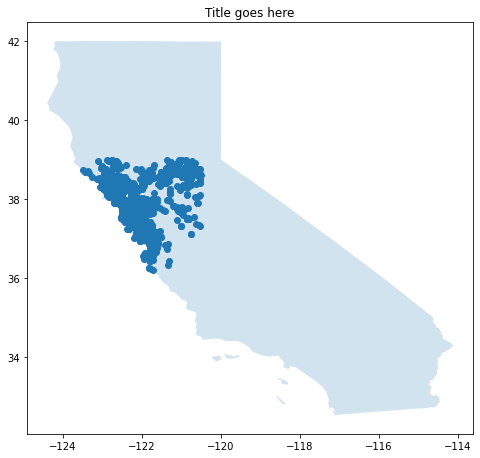

In [6]:

def get_geobox(df, center_lat=37.5, center_lon=-122, width_degrees=1.5):
  return df.loc[  \
                (df['lat'] > center_lat - width_degrees) & \
                (df['lat'] < center_lat + width_degrees) & \
                (df['lon'] < center_lon + width_degrees) & \
                (df['lon'] > center_lon - width_degrees) & \
                (df['location_type'] == 'outside')]



def make_CA_plot(df, title='Title goes here', size=(8, 8)):
    usa = gpd.read_file('states.shp')
    fig, ax = plt.subplots(figsize=size)
    usa[usa.STATE_ABBR == 'CA'].plot(ax=ax, alpha=0.2)
    
    point_data = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon, df.lat))
    #display(point_data.head())
    
    point_data.plot(ax=ax, legend=True)
    
    ax.set_title(title)

bay_area_sensors = get_geobox(df=sensors_df)

print(len(bay_area_sensors))
print(bay_area_sensors.columns)
display(bay_area_sensors.name)
make_CA_plot(df=bay_area_sensors)

In [8]:
def get_existing_sensor_files():
    filenames = os.listdir('data_daily')
    
    sensor_list = []
    
    for filename in filenames:
        first_stuff = filename.split('_')[0]
        sensor_number = first_stuff[6:]
        sensor_list.append(int(sensor_number))
        
    #print(len(sensor_list) - len(set(sensor_list)))
    
    return set(sensor_list)
    

def get_non_downloaded_sensor_list(full_list, print_report=False):
    full_sensor_set = set(bay_area_sensors.index)
    downloaded_sensor_set = get_existing_sensor_files()
    
    if print_report:
        print("Length of full set: {}".format(len(full_sensor_set)))
        print("Length of downloaded set: {}".format(len(downloaded_sensor_set)))
        print("Length of remaining: {}".format(len(full_sensor_set - downloaded_sensor_set)))
        print("Sample from full: {}".format(list(full_sensor_set)[0]))
        print("Sample from downloaded: {}".format(list(downloaded_sensor_set)[0]))
    
    return list(full_sensor_set - downloaded_sensor_set)


# let this loop run until all files are downloaded. If stopped and restarted, 
# this will check the directory's contents and pick up where it left off.
def bulk_load_daily(sensor_list):
    data_dir = 'daily_data_dump'
    
    if not os.path.exists(data_dir):
        print("data_dir doesn't exist")
        os.mkdir(data_dir, mode=0o666)
        print("made data_dir")
    
    curr_directory = os.path.dirname(os.getcwd())
    
    download_list = get_non_downloaded_sensor_list(
        full_list=sensor_list, 
        print_report=True)
    
    for i, sensor_num in enumerate(download_list):
        try: 
            start_time = time.time()
            se = Sensor(sensor_num)

            df = se.parent.get_daily(start_year=2018,
                                       start_month=5,
                                       end_year=2020,
                                       end_month=10,
                                        end_day = 13,
                                        thingspeak_field='secondary')

            file_name = "Sensor{}_daily.csv".format(sensor_num)

            outfile = os.path.join(
                os.getcwd(),
                'data_daily',
                file_name)

            df.to_csv(outfile)

            print("File {}/{}, duration={} seconds, {}".format(i, 
                            len(download_list), 
                            time.time() - start_time,
                            file_name
                    ))
            time.sleep(1)
        except BaseException as BE:
            print ("{}".format(BE))
            time.sleep(5)
            pass
        
bulk_load_daily(bay_area_sensors)


Length of full set: 3901
Length of downloaded set: 3888
Length of remaining: 18
Sample from full: 65547
Sample from downloaded: 65547
File 0/18, duration=2.4064040184020996 seconds, Sensor70113_daily.csv
File 1/18, duration=1.3699591159820557 seconds, Sensor78785_daily.csv
File 2/18, duration=1.3480000495910645 seconds, Sensor77635_daily.csv
File 3/18, duration=1.8323867321014404 seconds, Sensor76611_daily.csv
File 4/18, duration=4.39143705368042 seconds, Sensor22503_daily.csv
File 5/18, duration=1.4990849494934082 seconds, Sensor75529_daily.csv
File 6/18, duration=1.4957640171051025 seconds, Sensor78729_daily.csv
File 7/18, duration=6.5688698291778564 seconds, Sensor22409_daily.csv
File 8/18, duration=11.484323978424072 seconds, Sensor14891_daily.csv
File 9/18, duration=1.8607120513916016 seconds, Sensor22445_daily.csv
File 10/18, duration=7.594142913818359 seconds, Sensor23597_daily.csv
File 11/18, duration=2.6908700466156006 seconds, Sensor22451_daily.csv
File 12/18, duration=1.1507